In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
from scipy.optimize import minimize
import pandas as pd
import numpy
import math
from time import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 50
d_H = 10
width = 1024  # 1024
bias = False
n_steps = 10000
base_lr = 5.0e-3

target_p = 2
SEED = 42
num = 500
N_b = 1000

In [48]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/1d/{}'.format(width))
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

# 1. Initial Density $\tau_0$

If $X \sim B \left(\frac{d_H}{2}, \frac{d_\perp}{2} \right)$, then we have that $Y = \arccos \left(\sqrt{X} \right) \sim \tau_0$ where $$d\tau_0(\theta) = \frac{2}{B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right)} \cos(\theta)^{d_H - 1} \sin(\theta)^{d_\perp - 1} d\theta$$

In [9]:
def tau_0_density(theta, d_H=d_H, input_dim=input_dim):
    d = input_dim
    return 2 * (np.cos(theta) ** (d_H - 1)) * (np.sin(theta) ** (d-d_H -1)) / s.beta(d_H/2, (d-d_H)/2)

In [10]:
m = width 
d = input_dim

initial_cs = np.sign(np.random.uniform(low=-1., high=1.0, size=width))
initial_thetas = np.arccos(np.sqrt(np.random.beta(d_H/2, (d-d_H)/2, size=width)))
signs = np.copy(initial_cs)

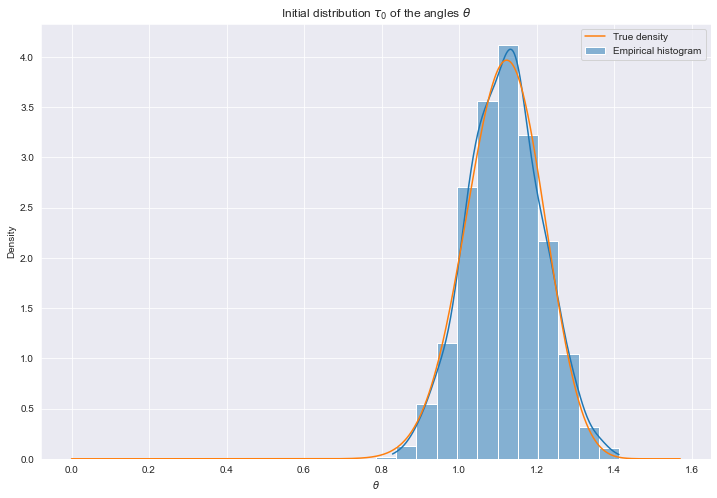

In [11]:
theta_grid = np.linspace(start=0., stop=np.pi/2, num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$\\theta$'])
data['$\\theta$'] = initial_thetas

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$\\theta$', stat='density', kde=True, binrange=(0., np.pi/2), bins=30, 
             label='Empirical histogram')
plt.plot(theta_grid, tau_0_density(theta_grid), color=colors[1], label='True density')
plt.title('Initial distribution $\\tau_0$ of the angles $\\theta$')
plt.legend()
plt.show()

### 1.1 Other distributions test

In [12]:
omegas = np.arccos(np.sqrt(np.random.beta(d_H/2, (d-d_H)/2, size=N_b))).reshape(-1)
qs = np.sqrt(np.random.beta(1/2, (d_H - 1)/2, size=(1, 2*N_b)))
vs = np.sqrt(np.random.beta(1/2, (d-d_H-1)/2, size=(1, 2*N_b)))
bernouillis = np.sign(np.random.uniform(low=-1., high=1.0, size=(2, 2*N_b)))
rs = (qs * bernouillis[0, :]).reshape(-1)
us = (vs * bernouillis[1, :]).reshape(-1)

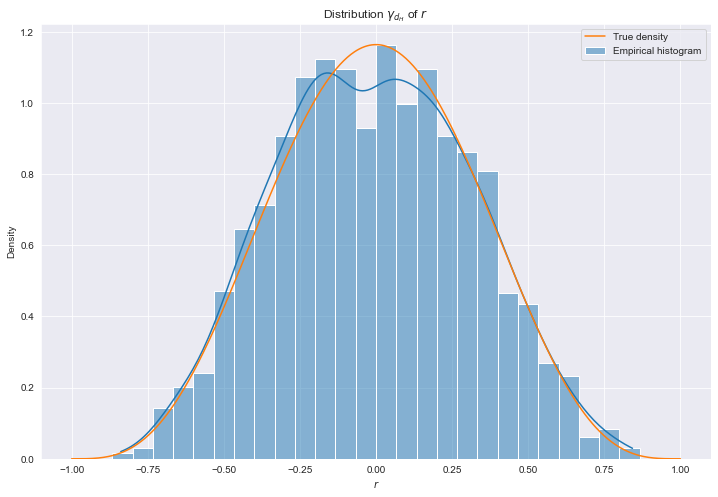

In [13]:
u_grid = np.linspace(start=-1., stop=1., num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$r$'])
data['$r$'] = rs

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$r$', stat='density', kde=True, binrange=(-1., 1.), bins=30, 
             label='Empirical histogram')
plt.plot(u_grid, (1 - u_grid**2)**((d_H-3)/2) / s.beta(1/2, (d_H-1)/2), color=colors[1], label='True density')
plt.title('Distribution $\gamma_{d_H}$ of $r$')
plt.legend()
plt.show()

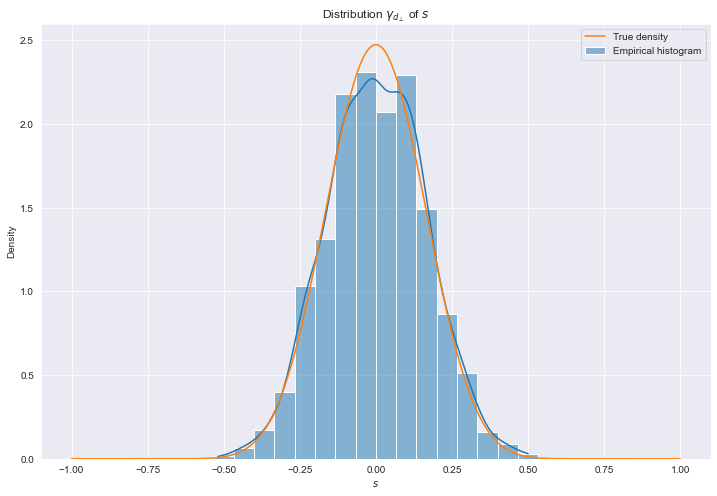

In [14]:
r_grid = np.linspace(start=-1., stop=1., num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['s$'])
data['$s$'] = us

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$s$', stat='density', kde=True, binrange=(-1., 1.), bins=30, 
             label='Empirical histogram')
plt.plot(u_grid, (1 - u_grid**2)**((d-d_H-3)/2) / s.beta(1/2, (d-d_H-1)/2), color=colors[1], label='True density')
plt.title('Distribution $\gamma_{d_\perp}$ of $s$')
plt.legend()
plt.show()

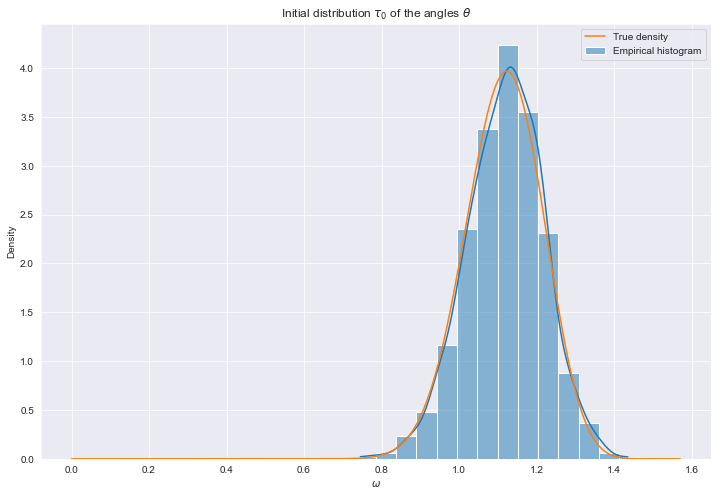

In [15]:
theta_grid = np.linspace(start=0., stop=np.pi/2, num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$\\omega$'])
data['$\\omega$'] = omegas

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$\\omega$', stat='density', kde=True, binrange=(0., np.pi/2), bins=30, 
             label='Empirical histogram')
plt.plot(theta_grid, tau_0_density(theta_grid), color=colors[1], label='True density')
plt.title('Initial distribution $\\tau_0$ of the angles $\\theta$')
plt.legend()
plt.show()

## 1.A. Tests at initialization

### A.I) Squared target average

In theory, the initial squared loss is $(1/2) \mathbb{E}[||y_H||^2]$ because the predictor is 0. After some computation, this should be equal to $d_H/2$. An integral appearing in this computation is 
\begin{align*}
    \int_\omega \cos(\omega)^2 d\tilde{\gamma}(\omega) =& d_H/d
\end{align*}
We will check that our sampling strategy yields the correct result.

In [16]:
print('d_H/d = {:.5f}'.format(d_H/input_dim))
val = np.sum(np.cos(omegas) **2 ) / N_b
print('Estimated value via MC sampling: {:.5f}'.format(val))

d_H/d = 0.20000
Estimated value via MC sampling: 0.19635


We will compute the inital $f(\tau_{m,0}; \omega)$ for $\omega$ first in a grid line over $[0, \pi/2]$ and second for $\omega$ sampled according to the initial distribution.

# 2. Simulation of the dynamic

## 2.1 Prediction function at initialization

Consider functions parameterized by $\tau = \tau_+ - \tau_- \in \mathcal{M}([0, \pi/2])$ where $\tau_\pm \in \mathcal{M}_+([0, \pi/2])$ as 
\begin{align}
    f(\tau; x) &= |\mathbb{S}^{d_H-2}|\, |\mathbb{S}^{d_\perp-2}| \int_{\theta} \phi(\theta; x) d\tau(\theta)
\end{align}
where 
\begin{align}
    \phi(\theta; x) = \int_{r,s} \sigma \Big(\cos(\theta) ||x_H|| r +  \sin(\theta) ||x_\perp|| s\Big) d\gamma_{d_H}(r) d\gamma_{d_\perp}(s)
\end{align}
where $d\gamma_{d_H}$ and $d\gamma_{d_\perp}$ are defined below. This can be re-written by re-parametrizing $x$ by its angle $\omega_x$ with $H$, using the positive $1$-homogeneity:
\begin{align}
    \phi(\theta; x) &= ||x|| \int_{r,s} \psi(\theta, \omega_x; r,s) d\gamma_{d_H}(r) d\gamma_{d_\perp}(s) \\
    \psi(\theta, \omega; r,s) &= \sigma \Big(\cos(\theta) \cos(\omega)  r +  \sin(\theta) \sin(\omega) s\Big)
\end{align}

In [17]:
def psi(r, u, theta, omega):
    return np.maximum(np.cos(theta) * (np.cos(omega) * r) + np.sin(theta) * (np.sin(omega) * u), 0)

Approximating 
\begin{align}
    I(\theta, \omega) := \int_{r,s \in [0,1]} \sigma \Big(\cos(\theta) \cos(\omega) r + \sin(\theta) \sin(\omega) s  \Big) d\gamma_{d_H}(r) d\gamma_{d_\perp}(s)
\end{align}
with 
\begin{align}
    d\gamma_{d_H}(r) &= (1 - r^2)^{(d_H-3)/2} \\
    d\gamma_{d_\perp}(s) &= (1 - s^2)^{(d_\perp-3)/2}
\end{align}
via Monte-Carlo sampling.

Sampling $R$ from $\gamma_{d_H}$ and $S$ from $\gamma_{d_\perp}$ is simply doing
\begin{align}
    R &= \sqrt{U}, \qquad U \sim B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \\
    S &= \sqrt{V}, \qquad V \sim B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right)
\end{align}
with the appropriate re-normalization, i.e., we have:
\begin{align}
    I(\theta, \omega) \simeq \frac{B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right)}{N} \sum_{k=1}^N \sigma \Big(\cos(\theta) \cos(\omega) R_k + \sin(\theta) \sin(\omega) S_k  \Big)
\end{align}

## 2.2 Dynamic and approximation of the reaction and drift terms

The gradient flow equations are as follows for any pair of (weight, position) indexed by $j$:
\begin{align}
    c_j'(t) &= 2 \varepsilon_j c_j(t) G_t(\theta_j(t)) \\
    \theta_j'(t) &= \varepsilon_j V_t(\theta_j(t))
\end{align}
which induce the following discretized updates:
\begin{align}
    c_j(k+1) &= \left(1 + 2 \eta \varepsilon_j G_t(\theta_j(k)) \right) c_j(k)  \\
    \theta_j(k+1) &= \theta_j(k) + \eta \varepsilon_j V_t(\theta_j(k))
\end{align}
where $\varepsilon_j$ is the initial sign of the $j$-th particle (i.e. $\varepsilon_j = c_j(0)$), and the drift term $V_t$ and the reaction term $G_t$ are
\begin{align}
    G_t(\theta) &= d \int_{\omega} R_t(\omega) \int_{r,s} \psi(\theta, \omega; r,s) d\tilde{\gamma}(\omega) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s) \\
    V_t(\theta) &= G_t'(\theta) = d \int_{\omega} R_t(\omega) \int_{r,s} \sigma' \Big( \cos(\theta) \cos(\omega)  r +  \sin(\theta) \sin(\omega) s\Big) \Big[-\sin(\theta) \cos(\omega)  r +  \cos(\theta) \sin(\omega) s \Big] d\tilde{\gamma}(\omega) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s)
\end{align}
where 
\begin{align}
    d\tilde{\gamma}(\omega) &= d\tau_0(\omega) \\
    R_t(\omega) &= \cos(\omega) - f(\tau_{m,t}; \omega) \\
\end{align}
with the discretization
\begin{align}
    \tau_{m,t} &= \frac{1}{m} \sum_{j=1}^m c_j(t) \delta_{\theta_j(t)} \\
    f(\tau_{m,t}; \omega) &= \frac{1}{m} \sum_{j=1}^m c_j(t) \phi(\theta_j(t); \omega)
\end{align}

We rely again on Monte-Carlo sampling to estimate the integrals defining $V_t$ and $G_t$, defining $\chi = \partial_\theta \psi$:
\begin{align}
    V_t(\theta) \simeq \frac{d }{N} \sum_{i=1}^N R_t(\Omega_i) \chi(\theta, \Omega_i; R_i, S_i) \\
    G_t(\theta) \simeq \frac{d }{N} \sum_{i=1}^N R_t(\Omega_i) \psi(\theta, \Omega_i; R_i, S_i)
\end{align}
where we have sampled
\begin{align}
    \Omega_i &= \arccos(\sqrt{\Lambda_i}), \qquad \Lambda_i \sim B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right) \\
    R_i &= \epsilon_i \sqrt{U_i}, \qquad U_i \sim B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \\
    S_i &= \epsilon_i \sqrt{V_i}, \qquad V_i \sim B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right) \\
    \epsilon &\sim \mathcal{U}(\{-1, 1\})
\end{align}

In [18]:
def chi(r, u, theta, omega):
    return ((1 + np.sign(np.cos(theta) * (np.cos(omega) * r) + np.sin(theta) * (np.sin(omega) * u)))/2 * 
            (np.cos(theta) * (np.sin(omega) * u) - np.sin(theta) * (np.cos(omega) * r)))

## 2.3 Simulating the dynamic by samling at each iteration

We follow the following procedure: $c_j(0)$ and $\theta_j(0)$ being suitably initialized, at each iteration $k$, we do:
1. draw $N_b$ samples $(\Lambda_i, U_i, V_i)$ from $B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right) \otimes B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \otimes B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right)$
2. compute $[R_t(\arccos(\sqrt{\Lambda_i}))]_i$ (using the pre-defined sampling for $f(\tau_{m, k})$) and append it to the list of previous residuals:
3. for every $j$ do
    * compute $[\psi(\theta_j(k), \arccos(\sqrt{\Lambda_i})); \sqrt{U_i}, \sqrt{V_i})]_i$ and $[\chi(\theta_j(k), \arccos(\sqrt{\Lambda_i})); \sqrt{U_i}, \sqrt{V_i})]_i$ in arrays,
    * compute the estimates 
    \begin{align*}
        \hat{V}_{k}(\theta_j(k)) &= \frac{d }{N_b} \sum_{i=1}^{N_b} R_t(\Omega_i) \chi(\theta_j(k), \Omega_i; R_i, S_i) \\
        \hat{G}_k(\theta_j(k)) &= \frac{d }{N_b} \sum_{i=1}^{N_b} R_t(\Omega_i) \psi(\theta_j(k), \Omega_i; R_i, S_i)
    \end{align*}
    * apply the updates
    \begin{align*}
        c_j(k+1) &= \left(1 + 2 \eta \varepsilon_j \hat{G}_k(\theta_j(k)) \right) c_j(k)  \\
        \theta_j(k+1) &= \theta_j(k) + \eta \varepsilon_j \hat{V}_k(\theta_j(k))
    \end{align*}
3. Add the $[c_j(k+1)]_j$ and $[\theta_j(k+1)]_j$ to the list of previous updates

To avoid having multiple different samplings, we put the termm $\cos(\omega)$ inside the integral defining $R_t(\omega)$ and thus consider $G_t$ and $V_t$ as integrals over the $5$ variables $(\omega, r, s, r', s')$. Being carefull with the constants, we find:
\begin{align*}
    G_t(\theta) &= d \int_{\omega, r, s, r', s'} \frac{\psi(\theta, \omega; r,s)}{m} \sum_{j=1}^m \Big(\cos(\omega) - c_j  \psi(\theta_j, \omega; r', s') \Big) d\tilde{\gamma}(\omega) (d\tilde{\gamma}_{d_H}(r,r'))^2 (d\tilde{\gamma}_{d_\perp}(s,s'))^2 \\
     V_t(\theta) &= d \int_{\omega, r, s, r', s'} \frac{\chi(\theta, \omega; r,s)}{m} \sum_{j=1}^m \Big(\cos(\omega) - c_j  \psi(\theta_j, \omega; r', s') \Big) d\tilde{\gamma}(\omega) (d\tilde{\gamma}_{d_H}(r,r'))^2 (d\tilde{\gamma}_{d_\perp}(s,s'))^2
\end{align*}
Calling $\mathbf{\Psi}$ and $\mathbf{\chi}$ the matrices such that 
\begin{align*}
    \mathbf{\Psi}_{j,i} &= \psi(\theta_j, \Omega_i; R_i, S_i) \\
    \mathbf{\hat{\Psi}}_{j,i} &= \psi(\theta_j, \Omega_i; R'_i, S'_i) \\
    \chi_{j,i} &= \chi(\theta_j, \Omega_i; R_i, S_i)
\end{align*}
we have the following update rules for the vectors $c = (c_j)_j$ and $\theta = (\theta_j)_j$:
\begin{align*}
    c(k+1) &= (1 + 2 \eta \varepsilon \odot \hat{G}_k) \odot c(k) \\
    \theta(k+1) &= \theta(k) + \eta \varepsilon \odot \hat{V}_k
\end{align*}
where 
\begin{align*}
    \hat{G}_k &= \frac{d}{N_b} \mathbf{\Psi} \left(\cos(\Omega) - \frac{1}{m} \mathbf{\hat{\Psi}}^\top c(k) \right) \\
    \hat{V}_k &= \frac{d}{N_b} \mathbf{\chi} \left(\cos(\Omega) - \frac{1}{m} \mathbf{\hat{\Psi}}^\top c(k) \right)
\end{align*}

As for the loss computation, it is given by 
\begin{align*}
    L_k =& \frac{2}{d} \tilde{L}_k \\
    \tilde{L}_k =& \frac{d_H}{d} - \frac{2}{N_b} \cos(\Omega)^\top \Psi^\top c(k) + c(k)^\top \Psi \tilde{\Psi}^\top c(k)
\end{align*}

In [19]:
residuals = []
cs = [initial_cs]
thetas = [initial_thetas]
losses = []

cs_k = np.copy(initial_cs)
thetas_k = np.copy(initial_thetas)

start = time()
for k in range(n_steps):
    
    # sampling at step k
    omegas = np.arccos(np.sqrt(np.random.beta(d_H/2, (d-d_H)/2, size=[1, N_b])))  

    qs_1 = np.sqrt(np.random.beta(1/2, (d_H - 1)/2, size=[1, N_b]))
    qs_2 = np.sqrt(np.random.beta(1/2, (d_H - 1)/2, size=[1, N_b]))
    vs_1 = np.sqrt(np.random.beta(1/2, (d-d_H-1)/2, size=[1, N_b]))
    vs_2 = np.sqrt(np.random.beta(1/2, (d-d_H-1)/2, size=[1, N_b]))

    bernouillis_1 = np.sign(np.random.uniform(low=-1., high=1.0, size=[2, N_b]))
    bernouillis_2 = np.sign(np.random.uniform(low=-1., high=1.0, size=[2, N_b]))

    rs_1 = qs_1 * bernouillis_1[0, :]
    us_1 = vs_1 * bernouillis_1[1, :]

    rs_2 = qs_2 * bernouillis_2[0, :]
    us_2 = vs_2 * bernouillis_2[1, :]
    
    # matrices and vectors at step k
    psi_mat = psi(rs_1, us_1, thetas_k.reshape(-1, 1), omegas)
    psi_tilde_mat_T = np.transpose(psi(rs_2, us_2, thetas_k.reshape(-1, 1), omegas))
    chi_mat = chi(rs_1, us_1, thetas_k.reshape(-1, 1), omegas)
    
    # residuals at step k
    f_tilde_k_omegas = np.matmul(psi_tilde_mat_T, cs_k) / width
    residuals_k = np.cos(omegas.reshape(-1)) - f_tilde_k_omegas
    residuals.append(np.copy(residuals_k))
    
    # loss at step k
    f_k_omegas = np.matmul(np.transpose(psi_mat), cs_k) / width             
    losses.append(0.5*(d_H/input_dim - 
                      (2 * np.inner(np.cos(omegas.reshape(-1)),  f_k_omegas) / N_b) + 
                      (np.inner(f_k_omegas, f_tilde_k_omegas)) / N_b)
                 ) 
    
    # V_hat and G_hat
    V_hat_k = (input_dim / N_b) * np.matmul(chi_mat, residuals_k)
    G_hat_k = (input_dim / N_b) * np.matmul(psi_mat, residuals_k)
    
    #cs_k = (1 + 2 * mult * base_lr * G_hat_k) * cs_k
    #thetas_k = thetas_k + mult * base_lr * V_hat_k

    cs_k = (1 + 2 * base_lr * signs * G_hat_k) * cs_k
    thetas_k = thetas_k + base_lr * signs * V_hat_k
    
    cs.append(np.copy(cs_k))
    thetas.append(np.copy(thetas_k))
    
end = time()
print('Time spent on {:,} steps: {:.2f} minutes'.format(k+1, (end - start)/60))
residuals = np.array(residuals)
cs = np.array(cs)
thetas = np.array(thetas)
losses = np.array(losses)

Time spent on 10,000 steps: 7.83 minutes


## Analysis

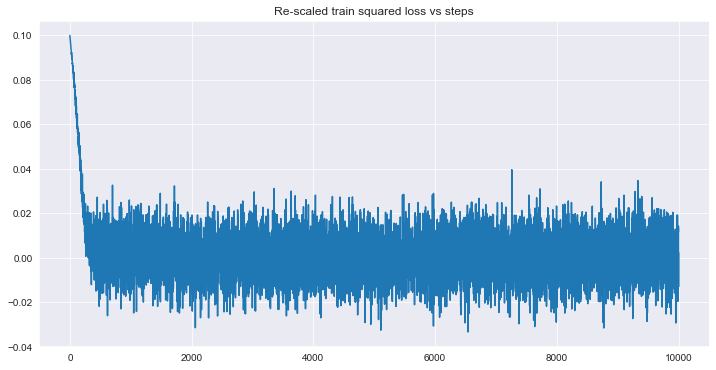

In [96]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(losses)), losses)
#plt.yscale('log')
plt.title('Re-scaled train squared loss vs steps')
plt.show()

In [21]:
thetas_plus = thetas[:, signs > 0]
thetas_minus = thetas[:, signs < 0]

cs_plus = cs[:, signs > 0]
cs_minus = cs[:, signs < 0]

In [26]:
thetas_plus.shape

(10001, 513)

In [27]:
thetas_minus.shape

(10001, 511)

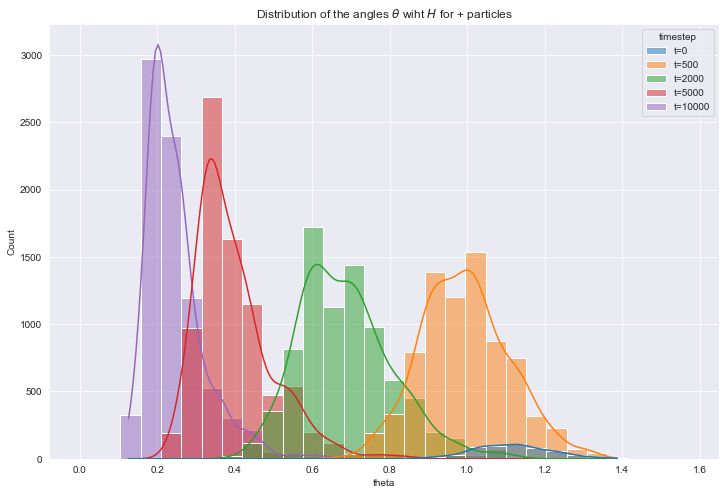

In [32]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_plus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='theta', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
             multiple='layer', weights='weight')
plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.show()

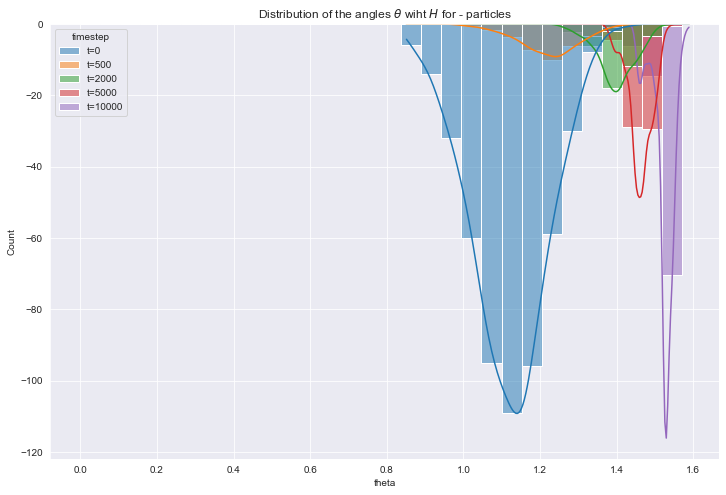

In [77]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_minus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_minus[ts, :].reshape(-1)
data['weight'] = -np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='theta', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
             multiple='layer', weights='weight')
plt.title('Distribution of the angles $\\theta$ wiht $H$ for - particles')
plt.show()

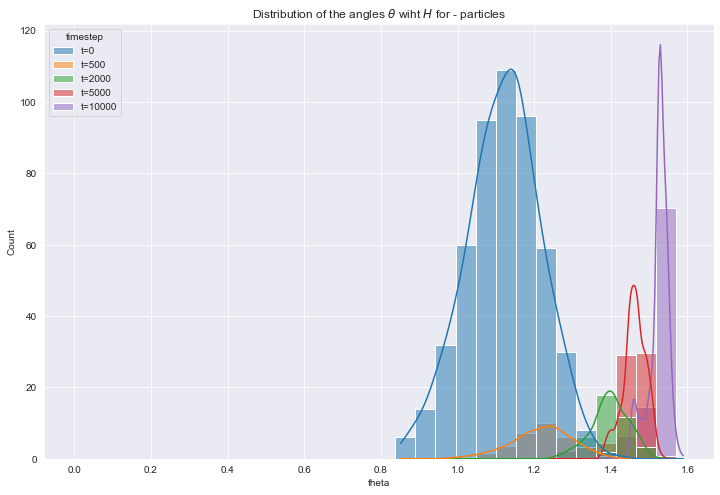

In [33]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_minus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_minus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='theta', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
             multiple='layer', weights='weight')
plt.title('Distribution of the angles $\\theta$ wiht $H$ for - particles')
plt.show()

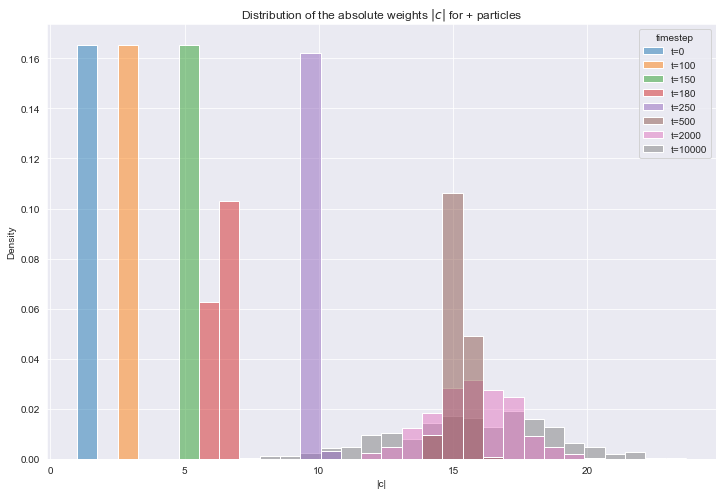

In [35]:
ts = [0, 100, 150, 180, 250, 500, 2000, 10000]
N = cs_plus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='|c|', hue='timestep', stat='density', kde=False, bins=30,
             multiple='layer')
plt.title('Distribution of the absolute weights $|c|$ for + particles')
plt.show()

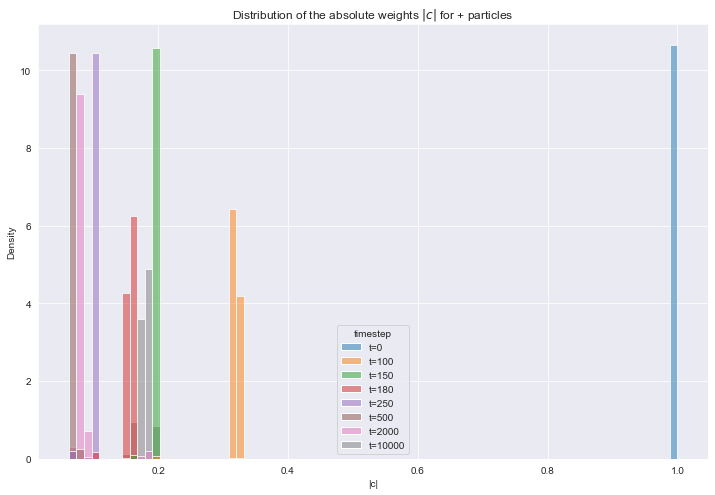

In [36]:
#ts = [0, 50, 100, 150, 180, 250, 300, 500, 1000, 2000, 5000, 8000, 10000]
ts = [0, 100, 150, 180, 250, 500, 2000, 10000]
N = cs_plus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='|c|', hue='timestep', stat='density', kde=False, bins=80,
             multiple='layer')
plt.title('Distribution of the absolute weights $|c|$ for + particles')
plt.show()

## Dynamic plots of histograms ?

In [49]:
num = 1000
fig_dir = 'theta_plus'
fig_name = 'step_{}.png'
fig_path = os.path.join(FIGURES_DIR, fig_dir, fig_name)
start = time()
ts = np.arange(start=0, stop=n_steps+2, step=int(n_steps/num))
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_plus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)

    
for t in ts:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=data.loc[data['timestep']=='t={}'.format(t), :], x='theta', stat='count', kde=True, 
                 binrange=(0., np.pi/2), bins=30, weights='weight')
    plt.savefig(fig_path.format(t))
    plt.close()
end = time()
print('Time for plotting and saving {:,} histograms: {:.2f} minutes'.format(num, (end - start )/ 60))

Time for plotting and saving 1,000 histograms: 4.92 minutes


In [51]:
num = 1000
fig_dir = os.path.join(FIGURES_DIR, 'theta_minus')
create_dir(fig_dir)
fig_path = os.path.join(fig_dir, 'step_{}.png')

start = time()
ts = np.arange(start=0, stop=n_steps+2, step=int(n_steps/num))
N = thetas_minus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_minus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)

    
for t in ts:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=data.loc[data['timestep']=='t={}'.format(t), :], x='theta', stat='count', kde=True, 
                 binrange=(0., np.pi/2), bins=30, weights='weight')
    plt.savefig(fig_path.format(t))
    plt.close()
end = time()
print('Time for plotting and saving {:,} histograms: {:.2f} minutes'.format(num, (end - start )/ 60))

Time for plotting and saving 1,000 histograms: 5.60 minutes


In [55]:
num = 1000
fig_dir = os.path.join(FIGURES_DIR, 'c_plus')
create_dir(fig_dir)
fig_path = os.path.join(fig_dir, 'step_{}.png')


start = time()
ts = np.arange(start=0, stop=n_steps+2, step=int(n_steps/num))
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
for t in ts:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=data.loc[data['timestep']=='t={}'.format(t), :], x='|c|', stat='density', kde=True, bins=30, 
                 binrange=(0., 20.0))
    plt.savefig(fig_path.format(t))
    plt.close()
end = time()
print('Time for plotting and saving {:,} histograms: {:.2f} minutes'.format(num, (end - start )/ 60))

Time for plotting and saving 1,000 histograms: 4.91 minutes


In [56]:
num = 1000
fig_dir = os.path.join(FIGURES_DIR, 'c_minus')
create_dir(fig_dir)
fig_path = os.path.join(fig_dir, 'step_{}.png')


start = time()
ts = np.arange(start=0, stop=n_steps+2, step=int(n_steps/num))
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
for t in ts:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=data.loc[data['timestep']=='t={}'.format(t), :], x='|c|', stat='density', kde=True, bins=30, 
                 binrange=(0., 1.0))
    plt.savefig(fig_path.format(t))
    plt.close()
end = time()
print('Time for plotting and saving {:,} histograms: {:.2f} minutes'.format(num, (end - start )/ 60))

Time for plotting and saving 1,000 histograms: 4.83 minutes


### Fancier histograms ? 

/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


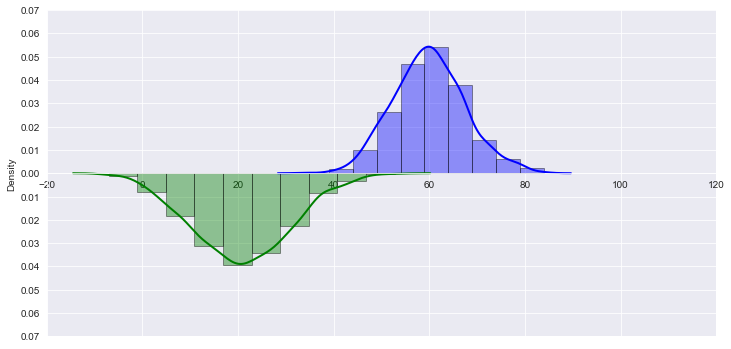

In [75]:
green = np.random.normal(20, 10, 1000)
blue = np.random.poisson(60, 1000)

fig, ax = plt.subplots(figsize=(12, 6))

sns.distplot(green, hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, bins=10,
             color='green', norm_hist=False)
for p in ax.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in ax.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.distplot(blue, hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, bins=10,
             color='blue', norm_hist=False)
ax.set_xticks(np.arange(-20, 121, 20))
ax.set_yticks(np.arange(0.0, 0.07, 0.01))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pos_ticks = np.array([t for t in ax.get_yticks() if t > 0])
ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{abs(t):.2f}' for t in ticks])
ax.spines['bottom'].set_position('zero')

plt.show()

In [76]:
np.stack([signs]*len(thetas)).shape

(10001, 1024)

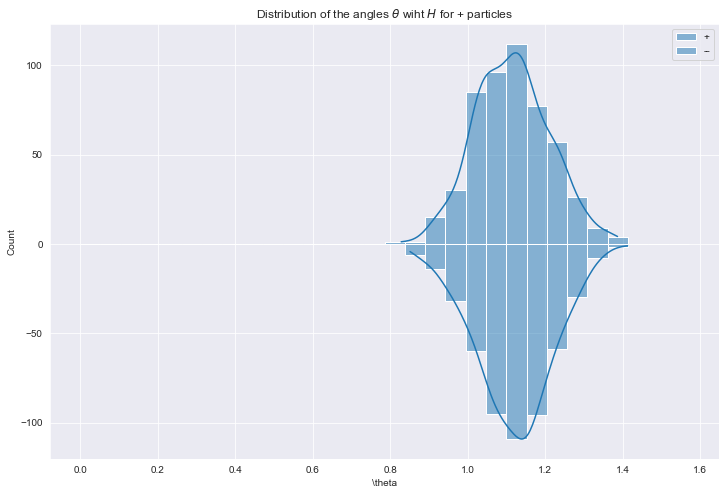

In [92]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 100, 500]

data = pd.DataFrame(columns=['timestep', '\\theta', 'sign', 'weight'])
data['\\theta'] = thetas[ts, :].reshape(-1)
data['sign'] = np.stack([signs]*len(ts)).reshape(-1)
data['sign'] = data['sign'].apply(lambda x: '+' if x > 0 else '--')
data['weight'] = cs[ts, :].reshape(-1)

for i, t in enumerate(ts):
    data.loc[i * width: (i+1) * width, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
for sign in ['+', '--']:
    #sns.histplot(data=data.loc[data['sign']==sign, :], x='\\theta', hue='timestep', stat='count', kde=True, 
    #             binrange=(0., np.pi/2), bins=30, multiple='layer', weights='weight', label=sign)
    #sns.histplot(data=data.loc[data['sign']==sign, :], x='\\theta', hue='timestep', stat='count', kde=True, 
    #             binrange=(0., np.pi/2), bins=30, multiple='layer', weights='weight', label=sign)
    
    sns.histplot(data=data.loc[data['sign']==sign, :], x='\\theta', stat='count', kde=True, 
                 binrange=(0., np.pi/2), bins=30, weights='weight', label=sign, )
plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.legend()
plt.show()

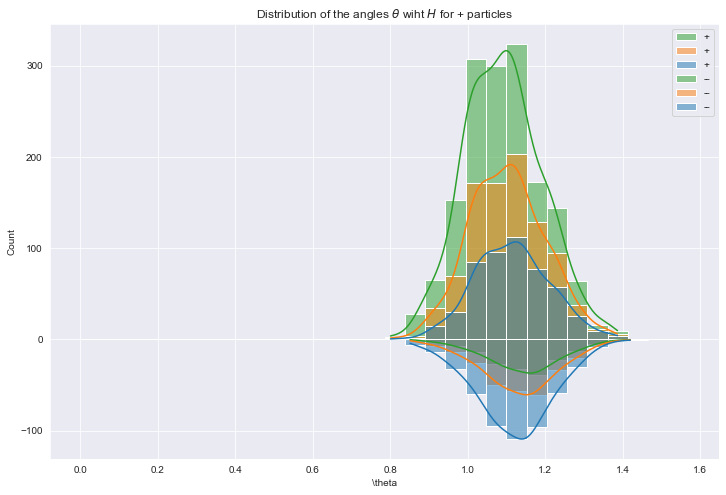

In [101]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 50, 100]

data = pd.DataFrame(columns=['timestep', '\\theta', 'sign', 'weight'])
data['\\theta'] = thetas[ts, :].reshape(-1)
data['sign'] = np.stack([signs]*len(ts)).reshape(-1)
data['sign'] = data['sign'].apply(lambda x: '+' if x > 0 else '--')
data['weight'] = cs[ts, :].reshape(-1)

for i, t in enumerate(ts):
    data.loc[i * width: (i+1) * width, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
for sign in ['+', '--']:
    sns.histplot(data=data.loc[data['sign']==sign, :], x='\\theta', hue='timestep', stat='count', kde=True, 
                 binrange=(0., np.pi/2), bins=30, multiple='layer', weights='weight', label=sign)
plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.legend()
plt.show()

In [98]:
data.loc[1000: 1060, :]

,timestep,\theta,sign,weight
1000,t=0,1.156141,--,-1.000000
1001,t=0,1.129669,+,1.000000
1002,t=0,1.062382,+,1.000000
1003,t=0,1.159912,+,1.000000
1004,t=0,1.064945,+,1.000000
...,...,...,...,...
1056,t=100,1.124834,--,-0.319530
1057,t=100,1.128428,+,3.085753
1058,t=100,1.138890,+,3.084413
1059,t=100,1.046297,+,3.097116
